In [1]:
#import packages
import pandas as pd
import numpy as np
import datetime

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style( 'whitegrid' )

# Parameters

In [17]:
pm = dict(
    h = 4,
)

In [18]:
h = pm['h']

# Load Data

In [3]:
#upload media.csv and markets.csv
media_data = pd.read_csv("../test_data/media.csv", index_col = 0, parse_dates = ['pub_date'])
markets_data = pd.read_csv("../test_data/markets.csv", parse_dates = ['Date'])
media_data.info()
markets_data.info() #unable to convert Date into datetime64 format

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   pub_date        100 non-null    datetime64[ns, UTC]
 1   abstract        100 non-null    object             
 2   lead_paragraph  100 non-null    object             
 3   snippet         98 non-null     object             
 4   headline.main   100 non-null    object             
 5   text            100 non-null    object             
 6   Polarity        100 non-null    float64            
 7   Sentiment       100 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(2), object(5)
memory usage: 7.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          209 non-null    object 
 1   Open         

In [6]:
#top 5 rows of media_data
media_data.head()

,pub_date,abstract,lead_paragraph,snippet,headline.main,text,Polarity,Sentiment
0,2022-10-25 20:37:03+00:00,Google’s parent company reported earnings that...,"Even Alphabet, the parent company of Google an...",Google’s parent company reported earnings that...,Alphabet’s Profit Drops 27 Percent From a Year...,Google’s parent company reported earnings that...,0.020616,0.920763
1,2022-10-26 22:47:44+00:00,A series of quarterly earnings reports is show...,Google this week reported a steep decline in p...,A series of quarterly earnings reports is show...,Tech’s Biggest Companies Are Sending Worrying ...,A series of quarterly earnings reports is show...,0.189792,0.321148
2,2022-10-20 15:05:58+00:00,"Ken Paxton, the state attorney general, said p...",The Texas attorney general filed a privacy law...,"Ken Paxton, the state attorney general, said p...",Texas Sues Google for Collecting Biometric Dat...,"Ken Paxton, the state attorney general, said p...",-0.949505,0.783947
3,2022-10-28 12:06:38+00:00,The social network’s new owner has just a few ...,Elon Musk closes his purchase of Twitter and f...,The social network’s new owner has just a few ...,Elon Musk Faces Another Big Decision at Twitter,The social network’s new owner has just a few ...,-0.812581,0.495369
4,2022-10-25 18:24:56+00:00,Apple has rejected Spotify’s new app three tim...,"Daniel Ek, the chief executive of Spotify, wan...",Apple has rejected Spotify’s new app three tim...,Spotify Wants to Get Into Audiobooks but Says ...,Apple has rejected Spotify’s new app three tim...,0.190357,0.728088


In [7]:
#top 5 rows of markets_data
markets_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2022-01-03 00:00:00-05:00,145.054993,145.850998,143.712997,144.991501,28646000,0.0,0.0
1,2022-01-04 00:00:00-05:00,145.395996,146.485001,143.716507,144.399506,28400000,0.0,0.0
2,2022-01-05 00:00:00-05:00,144.419998,144.499496,137.688004,137.774994,54618000,0.0,0.0
3,2022-01-06 00:00:00-05:00,136.998505,139.940002,136.558502,137.747498,37348000,0.0,0.0
4,2022-01-07 00:00:00-05:00,138.145493,138.448502,135.766495,137.016998,29760000,0.0,0.0


In [8]:
#changing the format of date and sorting the media_data by pub_date
media_data['pub_date'] = [date.strftime('%Y-%m-%d') for date in media_data['pub_date']]
markets_data['Date'] = [date.strftime('%Y-%m-%d') for date in markets_data['Date']]
media_data.sort_values(by='pub_date')

,pub_date,abstract,lead_paragraph,snippet,headline.main,text,Polarity,Sentiment
94,2022-01-06,The company will not be allowed to import prod...,"OAKLAND, Calif. — Google infringed on five aud...",The company will not be allowed to import prod...,"Google Infringed on Sonos Speaker Technology, ...",The company will not be allowed to import prod...,0.628086,0.920801
91,2022-01-10,The latest tranche totals about 200. They are ...,Google wrongly claimed attorney-client privile...,The latest tranche totals about 200. They are ...,Google must turn over more documents in a labo...,The latest tranche totals about 200. They are ...,-0.757070,0.883228
86,2022-01-14,The states argue that Google reached a deal wi...,Google’s chief executive approved an agreement...,The states argue that Google reached a deal wi...,Google’s chief executive signed off on deal at...,The states argue that Google reached a deal wi...,-0.267427,0.057614
87,2022-01-14,"The internet giant, planning on employees retu...",Google said Friday that it would spend $1 bill...,"The internet giant, planning on employees retu...",Google pays $1 billion for a London office bui...,"The internet giant, planning on employees retu...",-0.017825,0.799740
82,2022-01-20,"Mustafa Suleyman, who played a key role in the...","Mustafa Suleyman, a pioneer in the field of ar...","Mustafa Suleyman, who played a key role in the...",DeepMind co-founder leaves Google after a rock...,"Mustafa Suleyman, who played a key role in the...",-0.114581,0.843358
...,...,...,...,...,...,...,...,...
2,2022-10-20,"Ken Paxton, the state attorney general, said p...",The Texas attorney general filed a privacy law...,"Ken Paxton, the state attorney general, said p...",Texas Sues Google for Collecting Biometric Dat...,"Ken Paxton, the state attorney general, said p...",-0.949505,0.783947
4,2022-10-25,Apple has rejected Spotify’s new app three tim...,"Daniel Ek, the chief executive of Spotify, wan...",Apple has rejected Spotify’s new app three tim...,Spotify Wants to Get Into Audiobooks but Says ...,Apple has rejected Spotify’s new app three tim...,0.190357,0.728088
0,2022-10-25,Google’s parent company reported earnings that...,"Even Alphabet, the parent company of Google an...",Google’s parent company reported earnings that...,Alphabet’s Profit Drops 27 Percent From a Year...,Google’s parent company reported earnings that...,0.020616,0.920763
1,2022-10-26,A series of quarterly earnings reports is show...,Google this week reported a steep decline in p...,A series of quarterly earnings reports is show...,Tech’s Biggest Companies Are Sending Worrying ...,A series of quarterly earnings reports is show...,0.189792,0.321148


# Correlate Data

## Correlation

In [13]:
# Looping through all days in 2022, recording average polarity, sentiment, closing stock price on that day
# and closing stock price on day + h (given it's NOT a weekend)

Date = []
Average_Polarity = []
Average_Sentiment = []
Close = []
Close_h = [] # Closing stock price after date + 4 days (given it's a not weekend)

start_date = datetime.date(2022, 1, 1)
end_date = datetime.date(2022, 10, 25)
delta = datetime.timedelta(days = 1)

while (start_date <= end_date):
    if str(start_date) not in media_data.pub_date.values:
        start_date += delta
        continue
        
    Date.append(str(start_date))
    Average_Polarity.append(media_data.Polarity.loc[media_data.pub_date == str(start_date)].mean())
    Average_Sentiment.append(media_data.Sentiment.loc[media_data.pub_date == str(start_date)].mean())
    
    date1 = start_date
    while str(date1) not in markets_data.Date.values:
        date1 -= delta 
    Close.append(markets_data['Close'].loc[markets_data.Date == str(date1)].item())
    
    date2 = start_date + h * delta
    while str(date2) not in markets_data.Date.values:
        date2 += delta 
    Close_h.append(markets_data['Close'].loc[markets_data.Date == str(date2)].item())
    
    start_date += delta

In [15]:
Correlation_df = pd.DataFrame({'Date' : Date, 'Average_Polarity' : Average_Polarity, 'Average_Sentiment' : Average_Sentiment,
                     'Close' : Close, 'Close_h' : Close_h})

In [19]:
Correlation_df['Change_in_Close'] = Correlation_df['Close_h'] - Correlation_df['Close']

In [20]:
print(Correlation_df)

          Date  Average_Polarity  Average_Sentiment       Close     Close_h  \
0   2022-01-06          0.628086           0.920801  137.747498  138.669495   
1   2022-01-10         -0.757070           0.883228  138.669495  139.480499   
2   2022-01-14         -0.142626           0.428677  139.480499  135.998001   
3   2022-01-20         -0.114581           0.843358  133.307495  130.804001   
4   2022-01-21         -0.529412           0.713576  130.351501  126.934998   
..         ...               ...                ...         ...         ...   
76  2022-09-29         -0.390341           0.747738   97.419998   98.639999   
77  2022-10-12         -0.568492           0.831965   97.559998   99.970001   
78  2022-10-13         -0.628881           0.260670   99.059998   99.970001   
79  2022-10-20         -0.949505           0.783947   99.970001  102.519997   
80  2022-10-25          0.105487           0.824426  104.480003   94.510002   

    Change_in_Close  
0          0.921997  
1      

## Visualize

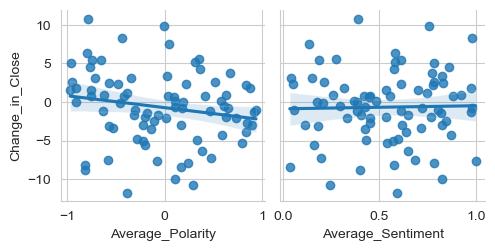

In [26]:
sns.pairplot(
    Correlation_df,
    x_vars = [ 'Average_Polarity', 'Average_Sentiment', ],
    y_vars = [ 'Change_in_Close', ],
    kind = 'reg',
)

Inverse correlation?? Need more data.